<a href="https://colab.research.google.com/github/siruku6/thesis-trial/blob/master/220818_VAE_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. 目次

1. 論文の概要
2. VAEの構造  
VAEのソースコード
3. 実験内容  
    - 学習対象データ  
    データロードのソースコード
    - 変化が加えられた実験条件  
    潜在変数の次元
4. ソースコード  
    - VAE for MNIST
    - VAE for Frey face
    - wake-sleep for MNIST
5. 参考資料

# 1. 論文の概要

　以下のような具体的なタスクを解く際のことを考える。

- (1) 自然現象の分析/解析を行う際に、隠されたランダムなプロセスを真似したり、現実に発生しうる**データを人工的に似せて生成**したりする
- (2) **符号化やデータ表現**のタスクを解く
- (3) コンピュータビジョンにおける、**ノイズ除去、マスクのある画像の再構成、超解像**

　上記のようなそれぞれのタスクにおいて、観察される事象をXとし、このXの発生にはランダムな生成プロセス（z：潜在変数）が背後に隠れていると仮定する。  

　この背後のプロセスzの分布の形状が、θというパラメータで決まるとすると、以下のような問題に直面する。

1. 周辺尤度 $p_\theta(x)=\int p_\theta(z)p_\theta(x|z)$ や、実際の確率密度 $p_\theta(z|x)=\frac{p_\theta(x|z)p_\theta(z)}{p_\theta(x)}$ を求めることができない。
1. データセットが大規模すぎて、バッチ最適化を行うコストが高過ぎる。


　著者らは、この２つの問題の対策として、本論文の VAE を提唱した。

# 2. VAEの構造

　VAEは、オートエンコーダに似た構造になっている。

　**オートエンコーダと同じ点**は、
- エンコーダ、デコーダ共に**MLPネットワーク**で構成されていること
- いわゆる最適化手法として、**確率的勾配法**を用いること

　**オートエンコーダと異なる点**は、
- エンコーダとデコーダの接続部分に工夫がなされていること  
VAEは、**潜在変数zが標準正規分布の形状になるべく近づく**ように作られている。  
そのために、エンコーダの最終層を2本に枝分かれさせ、2本のそれぞれの出力値を、潜在変数zの分布の「平均μ」と「分散σ」として取り扱っている。  
具体的には、このエンコーダの出力「μ」と「σ」は損失関数に使われており、標準正規分布から離れた分布になった場合には損失が大きくなるように設計されている。  



# 3. 実験内容

以下のデータセットそれぞれをVAEに学習させ、学習させたデータに似たデータが生成できるかを実験している。

- MNIST
- Frey face

タスクとしては、「1. 論文の概要」で挙げた(1)のタスクを実験対象としている。

また、著者らは実験中に、以下の条件を操作することによる結果も比較している。

- 潜在変数zの次元
    - MNISTの場合…3, 5, 10, 20, 200
    - Frey faceの場合…2, 5, 10, 20

その結果、潜在変数の次元数を増やしてもoverfittingしないことが確認されている。

# 4. ソースコード

※Google Colaboratory上で実行できる形で作成してあります。

## 4-1. Prepare Modules

In [ ]:
!pip install -q pytorch_lightning torchmetrics torchinfo

In [ ]:
from typing import List, Union

import numpy as np
import scipy.io as sio

# wake sleep
from itertools import islice

# VAE
import os

from tqdm.notebook import tqdm

import torch
import torch.utils.data
from torch import nn
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

# visualize chart
import pandas as pd
import matplotlib.pyplot as plt

# Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import torchmetrics
# from torchmetrics.functional import accuracy
from torchinfo import summary

## 4-2. Prepare data

### ※frey_faceを学習させる場合は、以下の `!wget` も実行しておく

In [ ]:
!wget https://cs.nyu.edu/~roweis/data/frey_rawface.mat -P data

--2022-08-18 01:24:37--  https://cs.nyu.edu/~roweis/data/frey_rawface.mat
Resolving cs.nyu.edu (cs.nyu.edu)... 216.165.22.203
Connecting to cs.nyu.edu (cs.nyu.edu)|216.165.22.203|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1100584 (1.0M)
Saving to: ‘data/frey_rawface.mat.2’

frey_rawface.mat.2  100%[===================>]   1.05M  1.17MB/s    in 0.9s    

2022-08-18 01:24:39 (1.17 MB/s) - ‘data/frey_rawface.mat.2’ saved [1100584/1100584]



In [ ]:
def get_dataloader(is_training_data: bool = True) -> torch.utils.data.DataLoader:
    location = "data/mnist"
    os.makedirs(location, exist_ok=True)
    dataloader = torch.utils.data.DataLoader(
        datasets.MNIST(
            location,
            train=is_training_data,
            download=True,
            transform=transforms.Compose([transforms.ToTensor()]),
        ),
        batch_size=100,
        shuffle=is_training_data,
    )
    return dataloader



# Loads Frey Face dataset
IMG_CHANNELS = 1
IMG_HEIGHT = 28
IMG_WIDTH = 20


def get_FreyFace_data_loader(
    batchSize: int = 100, is_training_data: bool = True
) -> torch.utils.data.DataLoader:
    ff = sio.loadmat('data/frey_rawface.mat')
    ff = ff["ff"].T  # .reshape((-1, IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH))
    ff = ff.astype('float32') / 255.
    size = len(ff)
    ff = ff[:int(size / batchSize) * batchSize]
    ff_torch = torch.from_numpy(ff)

    testStart = int(0.5 * size)
    if is_training_data:
        data_set = ff_torch[:testStart]
    else:
        data_set = ff_torch[testStart:]

    data_loader = torch.utils.data.DataLoader(data_set, batchSize, shuffle=is_training_data)
    return data_loader


## 4-3. Encoder / Decoder / Loss function

In [ ]:
class Encoder(nn.Module):
    """
    出力が潜在変数zの平均μと分散σ^2になるように、
    2本に分岐した出力を生成している
    """
    def __init__(self, in_out_dim: int, hidden_dim: int, latent_dim: int = 10):
        super().__init__()

        self.latent_dim = latent_dim
        self.common = nn.Sequential(
            nn.Linear(in_out_dim, hidden_dim),
            # nn.ReLU(),
            nn.Tanh(),
            )
        self.model1 = nn.Sequential(
            self.common,
            nn.Linear(hidden_dim, self.latent_dim)
            )
        self.model2 = nn.Sequential(
            self.common,
            nn.Linear(hidden_dim, self.latent_dim)
        )
        # for module in self.modules():
        #     if isinstance(module, nn.Linear):
        #         nn.init.normal_(module.weight, 0, 0.1)
        #         nn.init.constant_(module.bias, 0)

    def forward(self, img):
        """
        Returns
            (Tensor) List of latent codes
        """
        img_flat = img.view(img.size(0), -1)
        return self.model1(img_flat), self.model2(img_flat)


class Decoder(nn.Module):
    def __init__(self, in_out_dim: int, hidden_dim: int, latent_dim: int = 10):
        """

        """
        super().__init__()

        self.latent_dim = latent_dim
        self.model = nn.Sequential(
            nn.Linear(self.latent_dim, hidden_dim),
            # nn.ReLU(),
            nn.Tanh(),
            nn.Linear(hidden_dim, in_out_dim),
            nn.Sigmoid(),
        )
        # for module in self.modules():
        #     if isinstance(module, nn.Linear):
        #         nn.init.normal_(module.weight, 0, 0.1)
        #         nn.init.constant_(module.bias, 0)

    def forward(self, z):
        return self.model(z)


def VAE_LOSS(recon_x, x, mu, logvar, data_size: int):
    """
    カルバックライブラ―ダイバージェンス(KLD)を利用することで、
    潜在変数zが標準正規分布から離れた場合には損失の値が大きくなるように設計されている

    see Appendix B from VAE paper:
    Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    https://arxiv.org/abs/1312.6114
    0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    """
    reconstruction_loss = F.binary_cross_entropy(recon_x, x.view(-1, data_size), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + KLD


## 4-4. Run experiment

以降は、MNISTとFrey faceで別々の実装を行う。

実装を分けている理由は、「若干ネットワークの構造に違いがある」という実装上の問題があるためであり、実験内容自体には違いはない。


### 4-4-1. VAE for MNIST

#### 4-4-1-1. Integrate Encoder, Decoder and Loss fucntion into VAE network

エンコーダ、デコーダ、損失関数などを組み合わせて、VAEのネットワークを構築する

In [ ]:
class VAE(pl.LightningModule):
    def __init__(
        self,
        in_out_dim: int,
        hidden_dim: int,
        latent_dim: int = 10
    ):
        super().__init__()

        self.in_out_dim = in_out_dim
        self.encoder = Encoder(in_out_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(in_out_dim, hidden_dim, latent_dim)

    def _reparameterization_trick(self, mean, logvar):
        """
        デコーダ―の出力からエンコーダーの入力層まで誤差逆伝播できるようにするため、
        エンコーダーの出力である潜在変数 z を μ + εσ という計算で表現している

        Parameters
            mean: (Tensor) Mean of the latent Gaussian [B x D]
            logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]

        Returns
            (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mu, sigma = self.encoder(x)
        z         = self._reparameterization_trick(mu, sigma)
        generated = self.decoder(z)
        return generated, mu, sigma

    def training_step(self, batch, batch_idx):
        real_images, _ = batch
        gen_imgs, mu, logvar = self(real_images)
        loss = VAE_LOSS(gen_imgs, real_images, mu, logvar, self.in_out_dim)
        self.log('train_loss', -loss / len(real_images), on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        real_images, _ = batch
        gen_imgs, mu, logvar = self(real_images)
        loss = VAE_LOSS(gen_imgs, real_images, mu, logvar, self.in_out_dim)
        self.log('val_loss', -loss / len(real_images), on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        real_images, _ = batch
        gen_imgs, mu, logvar = self(real_images)
        loss = VAE_LOSS(gen_imgs, real_images, mu, logvar, self.in_out_dim)
        self.log('test_loss', -loss / len(real_images), on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        # optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-8)
        optimizer = torch.optim.Adagrad(self.parameters(), lr=0.01, weight_decay=5e-4)
        # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1)
        return {
            'optimizer': optimizer,
            # 'lr_scheduler': {'scheduler': scheduler, 'monitor': 'val_loss',}
        }

    def sample(self, num_samples: int, current_device: str = 'cpu') -> torch.Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.

        Parameters
            num_samples: (Int) Number of samples
            current_device: (Int) Device to run the model

        Returns
            (Tensor)
        """
        z = torch.randn(num_samples, self.decoder.latent_dim)
        z = z.to(current_device)

        samples = self.decoder(z)
        return samples

    def make_manifold(self, num_x: int, num_y: int):
        """
        潜在変数zを1データ分ランダムに設定し、
        そのz周辺の潜在変数の画像を生成する
        """
        assert self.encoder.latent_dim == 2, f'潜在変数が2の場合のみ実行可能です。現在の潜在変数: {self.encoder.latent_dim}'

        self.eval().cpu()

        z = torch.randn(1, self.decoder.latent_dim)
        # z = z.to(current_device)

        step_x = 2.0 / num_x
        step_y = 2.0 / num_y

        inputs = []
        for i in range(num_x):
            z_new = z.clone()
            z_new[0, 0] -= 1.0
            z_new[0, 0] += step_x * i
            for j in range(num_y):
                z_new[0, 1] -= 1.0
                z_new[0, 1] += step_y * j
                z_new = z_new.abs()
                inputs.append(z_new)

        inputs = Variable(torch.cat(inputs, 0))
        print(inputs.shape)
        outputs = self.decoder(inputs)

        toshow = outputs.cpu().data.numpy()
        return toshow


#### 4-4-1-2. check behaviour of Decoder

学習を行う前の VAE にランダムな潜在変数を与えて、どんな出力Xが生成されるか確認する。

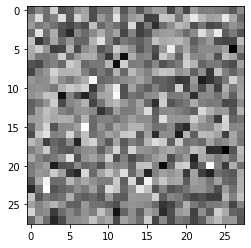

In [ ]:
data_loader = get_dataloader(True)
img = next(iter(data_loader))

sample_vae = VAE(in_out_dim=28 * 28, hidden_dim=500)
sample_vae.eval()

result = sample_vae(img[0])
result[0].shape

# Plot
pixels = result[0][1].detach().numpy().reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()


学習前のため、意味のある出力は現れない。

#### 4-4-1-3. Training VAE

In [ ]:
pl.seed_everything(0)

logger = CSVLogger(save_dir='logs', name='vae_net')

if torch.cuda.is_available():
    trainer = pl.Trainer(max_epochs=10, accelerator='gpu', devices=1, deterministic=True, logger=logger)
else:
    trainer = pl.Trainer(max_epochs=10, deterministic=True, logger=logger)

# MNIST
vae = VAE(in_out_dim=28 * 28, hidden_dim=500, latent_dim=2)
train_loader = get_dataloader(True)
val_loader = get_dataloader(False)
trainer.fit(vae, train_loader, val_loader)


INFO:pytorch_lightning.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 394 K 
1 | decoder | Decoder | 394 K 
------------------------------------
788 K     Trainable params
0         Non-trainable params
788 K     Total params
3.155     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


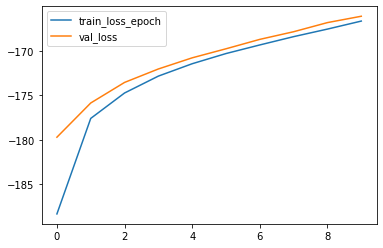

In [ ]:
# 結果確認 Adagrad without initializers Tanh 10 epochs (MNIST)
log = pd.read_csv('logs/vae_net/version_0/metrics.csv')

log[['train_loss_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss_epoch'].plot()
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot()
plt.legend()

#### 4-4-1-4. 学習後の Decoder でXを生成

学習後のDecoderに対し、ランダムな潜在変数を与えてXを生成する。

  0%|          | 0/50 [00:00<?, ?it/s]

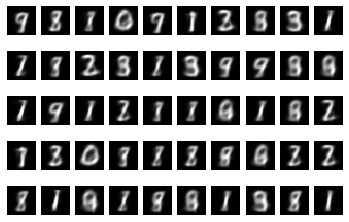

In [ ]:
num: int = 50
imgs = vae.sample(num)

with torch.no_grad():
    for i in tqdm(range(num)):
        x = imgs[i].reshape((28, 28))
        plt.subplot(5, 10, i + 1)
        plt.imshow(x, interpolation='nearest', cmap = "gray")
        plt.axis('off')

学習後は、潜在変数の傾向を学習したDecoderにより、学習データに似た傾向のデータが生成される。

#### 4-4-1-5. 学習後のmanifoldの表示

In [ ]:
# # モデルの保存
# model_file_name: str = 'vae.pt'
# torch.save(vae.state_dict(), model_file_name)


torch.Size([100, 2])


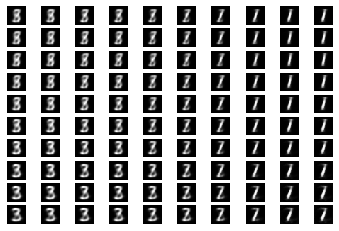

In [ ]:
# vae = VAE(in_out_dim=28 * 28, hidden_dim=500, latent_dim=2).cpu().eval()
# vae.load_state_dict(torch.load(model_file_name, map_location=torch.device('cpu')))

num_x = 10
num_y = 10
manifold = vae.make_manifold(num_x, num_y)
manifold.shape

for i in range(num_x * num_y):
    x = manifold[i].reshape((28, 28))
    plt.subplot(num_x, num_y, i + 1)
    plt.imshow(x, interpolation='nearest', cmap = "gray")
    plt.axis('off')

### 4-4-2. VAE for Frey face

#### 4-4-2-1. Integrate Encoder, Decoder and Loss fucntion into VAE network

エンコーダ、デコーダ、損失関数などを組み合わせて、VAEのネットワークを構築する

In [ ]:
class VAE(pl.LightningModule):
    def __init__(
        self,
        in_out_dim: int,
        hidden_dim: int,
        latent_dim: int = 10
    ):
        super().__init__()

        self.in_out_dim = in_out_dim
        self.encoder = Encoder(in_out_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(in_out_dim, hidden_dim, latent_dim)

    def _reparameterization_trick(self, mean, logvar):
        """
        Parameters
            mean: (Tensor) Mean of the latent Gaussian [B x D]
            logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]

        Returns
            (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mu, sigma = self.encoder(x)
        z         = self._reparameterization_trick(mu, sigma)
        generated = self.decoder(z)
        return generated, mu, sigma

    def training_step(self, batch, batch_idx):
        real_images = batch
        gen_imgs, mu, logvar = self(real_images)
        loss = VAE_LOSS(gen_imgs, real_images, mu, logvar, self.in_out_dim)
        self.log('train_loss', -loss / len(real_images), on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        real_images = batch
        gen_imgs, mu, logvar = self(real_images)
        loss = VAE_LOSS(gen_imgs, real_images, mu, logvar, self.in_out_dim)
        self.log('val_loss', -loss / len(real_images), on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        real_images = batch
        gen_imgs, mu, logvar = self(real_images)
        loss = VAE_LOSS(gen_imgs, real_images, mu, logvar, self.in_out_dim)
        self.log('test_loss', -loss / len(real_images), on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        # optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-8)
        optimizer = torch.optim.Adagrad(self.parameters(), lr=0.01, weight_decay=5e-4)

        # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1)
        return {
            'optimizer': optimizer,
            # 'lr_scheduler': {'scheduler': scheduler, 'monitor': 'val_loss',}
        }

    def sample(self, num_samples: int, current_device: str = 'cpu') -> torch.Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.

        Parameters
            num_samples: (Int) Number of samples
            current_device: (Int) Device to run the model

        Returns
            (Tensor)
        """
        z = torch.randn(num_samples, self.decoder.latent_dim)
        z = z.to(current_device)

        samples = self.decoder(z)
        return samples

    def make_manifold(self, num_x: int, num_y: int):
        """
        潜在変数zを1データ分ランダムに設定し、
        そのz周辺の潜在変数の画像を生成する
        """
        assert self.encoder.latent_dim == 2, f'潜在変数が2の場合のみ実行可能です。現在の潜在変数: {self.encoder.latent_dim}'

        self.eval().cpu()

        z = torch.randn(1, self.decoder.latent_dim)

        step_x = 2.0 / num_x
        step_y = 2.0 / num_y

        inputs = []
        for i in range(num_x):
            z_new = z.clone()
            z_new[0, 0] -= 1.0
            z_new[0, 0] += step_x * i
            for j in range(num_y):
                z_new[0, 1] -= 1.0
                z_new[0, 1] += step_y * j
                z_new = z_new.abs()
                inputs.append(z_new)

        inputs = Variable(torch.cat(inputs, 0))
        outputs = self.decoder(inputs)

        toshow = outputs.cpu().data.numpy()
        return toshow


#### 4-4-2-2. check behaviour of Decoder

学習を行う前の VAE にランダムな潜在変数を与えて、どんな出力Xが生成されるか確認する。

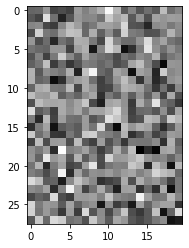

In [ ]:
# NOTE: 4-2. で !wget を実行していないと、
#   ここで "FileNotFoundError: [Errno 2] No such file or directory: 'data/frey_rawface.mat'" が発生する
data_loader = get_FreyFace_data_loader(is_training_data=True)
img = next(iter(data_loader))

sample_vae = VAE(in_out_dim=28 * 20, hidden_dim=200)
sample_vae.eval()

result = sample_vae(img)

# Plot
pixels = result[0][0].detach().numpy().reshape((28, 20))
plt.imshow(pixels, cmap='gray')
plt.show()


学習前のため、意味のある出力は得られない。

#### 4-4-2-3. Training VAE

In [ ]:
pl.seed_everything(0)

logger = CSVLogger(save_dir='logs', name='vae_face_net')

if torch.cuda.is_available():
    trainer = pl.Trainer(max_epochs=50, accelerator='gpu', devices=1, deterministic=True, logger=logger)
else:
    trainer = pl.Trainer(max_epochs=50, deterministic=True, logger=logger)

# Fray face
vae_frey_face = VAE(in_out_dim=28 * 20, hidden_dim=200, latent_dim=2)

# NOTE: 4-2. で !wget を実行していないと、
#   ここで "FileNotFoundError: [Errno 2] No such file or directory: 'data/frey_rawface.mat'" が発生する
train_loader = get_FreyFace_data_loader(is_training_data=True)
val_loader = get_FreyFace_data_loader(is_training_data=False)
trainer.fit(vae_frey_face, train_loader, val_loader)


INFO:pytorch_lightning.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 113 K 
1 | decoder | Decoder | 113 K 
------------------------------------
226 K     Trainable params
0         Non-trainable params
226 K     Total params
0.905     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1898: PossibleUserWarning: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


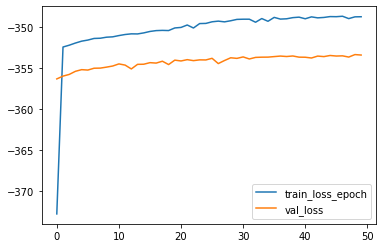

In [ ]:
# 結果確認
log = pd.read_csv('logs/vae_face_net/version_0/metrics.csv')

log[['train_loss_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss_epoch'].plot()
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot()
plt.legend()

#### 4-4-2-4. 学習後の Decoder でXを生成

学習後のDecoderに対し、ランダムな潜在変数を与えてXを生成する。

  0%|          | 0/50 [00:00<?, ?it/s]

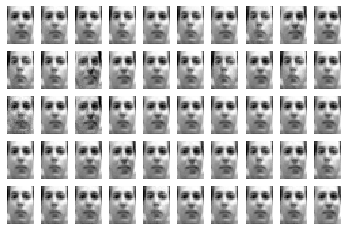

In [ ]:
num: int = 50

with torch.no_grad():
    imgs = vae_frey_face.sample(num)

for i in tqdm(range(num)):
    x = imgs[i].reshape((28, 20))

    plt.subplot(5, 10, i + 1)
    plt.imshow(x, interpolation='nearest', cmap = "gray")
    plt.axis('off')

#### 4-4-2-5. 学習後のmanifoldの表示

manifoldを表示させると、潜在変数の値が近いところには、似たような画像が集まっていることが分かる。

torch.Size([100, 2])


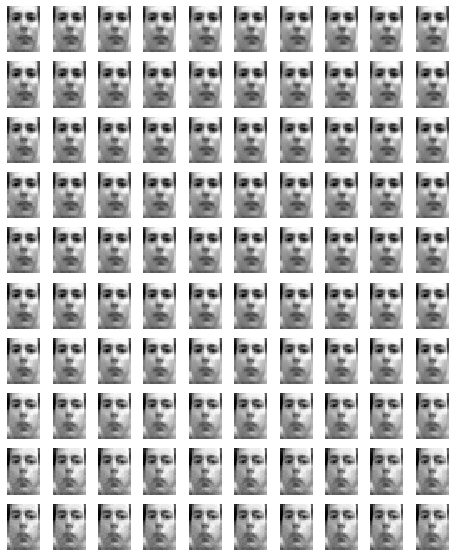

In [ ]:
num_x = 10
num_y = 10
manifold = vae_frey_face.make_manifold(num_x, num_y)
manifold.shape

fig, axs = plt.subplots(num_x, num_y, figsize=(8, 10))
fig.subplots_adjust(wspace=0.2, hspace=0.2)

for i in range(num_x):
    for j in range(num_y):
        x = manifold[i + 10 * j].reshape((28, 20))

        # plt.subplot(num_x, num_y, i + 1, figsize=(12, 8))
        axs[i, j].imshow(x, interpolation='nearest', cmap = "gray")
        axs[i, j].axis('off')


### 4-4-3. WakeSleep for MNIST

「4-4-1. VAE for MNIST」の比較対象として、WakeSleepでMNISTデータを学習させる

#### 4-4-3-1. ネットワーク実装

In [ ]:
class HelmholtzMachine(pl.LightningModule):
    """
    A Helmholtz machine trained with the Wake Sleep algorithm.
    """
    _awake = True

    def __init__(
        self,
        in_out_dim: int,
        hidden_dim: int,
        latent_dim: int = 10,
        # layers: List[int],
        verbose: bool = False,
    ):
        super(HelmholtzMachine, self).__init__()

        # recognition layers
        self.recognition_0 = nn.Linear(in_out_dim, hidden_dim)
        self.recognition_1 = nn.Linear(hidden_dim, latent_dim)

        # generation layers
        self.generation_0 = nn.Linear(latent_dim, hidden_dim)
        self.generation_1 = nn.Linear(hidden_dim, in_out_dim)

        self.g_bias = Parameter(torch.FloatTensor(latent_dim))

        self.reset_parameters()
        self._verbose = verbose

    def reset_parameters(self):
        self.g_bias.data.uniform_(-1, 1)

    def wake(self):
        self._awake = True

    def sleep(self):
        self._awake = False

    def layer_output(self, x, training=True):
        """
        If training, treat x as bernoulli distribution and sample output,
        otherwise simply round x, giving binary output in either case.
        """
        if training:
            out = torch.bernoulli(x).detach()
        else:
            out = torch.round(x)
        return out

    def _run_wake_recognition(self, x):
        # Run recognition layers, saving stochastic outputs.
        x = self.recognition_0(x)
        x = torch.sigmoid(x)
        x = self.layer_output(x, self.training)
        result1 = x

        x = self.recognition_1(x)
        x = torch.sigmoid(x)
        x = self.layer_output(x, self.training)
        result2 = x

        return result1, result2

    def _run_wake_generation(self, x_original, recognition_outputs):
        x_input = recognition_outputs[-1]
        x_target = recognition_outputs[-2]
        x = self.generation_0(x_input)
        x = torch.sigmoid(x)
        result1 = nn.BCELoss(reduction='sum')(x, x_target)

        x_input = recognition_outputs[-2]
        x_target = x_original
        x = self.generation_1(x_input)
        x = torch.sigmoid(x)
        result2 = nn.BCELoss(reduction='sum')(x, x_target)

        return result1, result2

    def run_wake(self, x):
        x_first = x
        batch_size = x.size(0)

        # Run Recognition Net.
        recognition_outputs = self._run_wake_recognition(x)

        # Fit the bias to the final layer.
        x_last = recognition_outputs[-1]
        x = self.g_bias.view(1, -1).expand(batch_size, self.g_bias.size(0))
        x = torch.sigmoid(x)
        generation_bias_loss = nn.BCELoss(reduction='sum')(x, x_last)

        # Run Generation Net.
        generation_loss = self._run_wake_generation(x_first, recognition_outputs)

        return recognition_outputs, generation_bias_loss, generation_loss

    def _run_sleep_recognition(self, x_initial, generative_outputs):
        x_input = generative_outputs[-1]
        x = self.recognition_0(x_input)
        x = torch.sigmoid(x)
        x_target = generative_outputs[-2]
        result1 = nn.BCELoss(reduction='sum')(x, x_target)

        x_input = generative_outputs[-2]
        x = self.recognition_1(x_input)
        x = torch.sigmoid(x)
        x_target = x_initial
        result2 = nn.BCELoss(reduction='sum')(x, x_target)

        return result1, result2

    def _run_sleep_generation(self, x_initial):
        # Fantasize each layers output.
        x = self.generation_0(x_initial)
        x = torch.sigmoid(x)
        x = self.layer_output(x, self.training)
        result1 = x

        x = self.generation_1(x)
        x = torch.sigmoid(x)
        x = self.layer_output(x, self.training)
        result2 = x

        return result1, result2

    def run_sleep(self, x):
        batch_size = x.size(0)
        recognition_loss = []

        # We do not use the input `x`, rather we use the bias.
        bias = self.g_bias.view(1, -1)
        x = torch.sigmoid(bias)
        x = x.expand(batch_size, self.g_bias.size(0))
        x = self.layer_output(x, self.training)
        generation_bias_output = x

        # Fantasize each layers output.
        generative_outputs = self._run_sleep_generation(generation_bias_output)

        # Run recognition layers to predict fantasies.
        recognition_loss = self._run_sleep_recognition(generation_bias_output, generative_outputs)

        return recognition_loss, generation_bias_output, generative_outputs

    def forward(self, x):
        x = x.view(x.size(0), -1)

        _, generation_bias_loss, generative_loss = self.run_wake(x)
        recognition_loss, _, generative_outputs = self.run_sleep(x)

        total_loss = 0.0
        total_loss += generation_bias_loss
        for i, loss in enumerate(generative_loss):
            total_loss += loss
        for i, loss in enumerate(recognition_loss):
            total_loss += loss
        return total_loss, generative_outputs

    def training_step(self, batch, batch_idx):
        real_images, _ = batch
        # real_images = batch
        loss, _ = self(real_images)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        real_images, _ = batch
        # real_images = batch
        loss, _ = self(real_images)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        real_images, _ = batch
        # real_images = batch
        loss, _ = self(real_images)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2, weight_decay=1e-8)
        # optimizer = torch.optim.Adagrad(self.parameters(), lr=0.1, weight_decay=5e-4)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {'scheduler': scheduler, 'monitor': 'val_loss',}
        }

    def sample(self, num_samples: int, current_device: str = 'cpu') -> torch.Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.

        Parameters
            num_samples: (Int) Number of samples
            current_device: (Int) Device to run the model

        Returns
            (Tensor)
        """
        z = torch.randn(num_samples, self.g_bias.size()[0])
        z = z.to(current_device)

        print(z.shape)

        samples = self._run_sleep_generation(z)
        return samples[-1].cpu().data.view(-1, 28, 28).numpy()

    def manifold(self, num_x: int, num_y: int):
        """
        潜在変数zをランダムに設定し、その値から画像を生成する
        """
        self.eval().cpu()

        x_base = torch.randn(self.g_bias.view(1, -1).size())
        x_base = x_base.data

        step_x = 2.0 / num_x
        step_y = 2.0 / num_y

        inputs = []
        for i in range(num_x):
            z_new = x_base.clone()
            z_new[0, 0] -= 1.0
            z_new[0, 0] += step_x * i
            for j in range(num_y):
                z_new[0, 1] -= 1.0
                z_new[0, 1] += step_y * j
                z_new = z_new.abs()
                inputs.append(z_new)

        inputs = Variable(torch.cat(inputs, 0))
        outputs = self._run_sleep_generation(inputs)

        toshow = outputs[-1].cpu().data.view(-1, 28, 28).numpy()
        return toshow



#### 4-4-3-2. ネットワーク動作確認

torch.Size([100, 784])


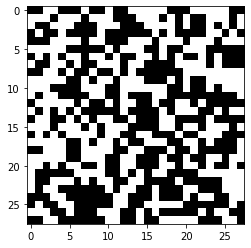

In [ ]:
data_loader = get_dataloader(True)
img = next(iter(data_loader))

helm = HelmholtzMachine(in_out_dim=28 * 28, hidden_dim=500)
helm.eval()

print(img[0].reshape(-1, 28 * 28).shape)

loss, output = helm(img[0])

# Plot
pixels = output[-1].detach().numpy().reshape((-1, 28, 28))[0]
plt.imshow(pixels, cmap='gray')
plt.show()

#### 4-4-3-3. 学習

In [ ]:
pl.seed_everything(0)

logger = CSVLogger(save_dir='logs', name='helm_net')

if torch.cuda.is_available():
    trainer = pl.Trainer(max_epochs=10, accelerator='gpu', devices=1, deterministic=True, logger=logger)
else:
    trainer = pl.Trainer(max_epochs=10, deterministic=True, logger=logger)

# MNIST
helm = HelmholtzMachine(in_out_dim=28 * 28, hidden_dim=500, latent_dim=2)
train_loader = get_dataloader(True)
val_loader = get_dataloader(False)

trainer.fit(helm, train_loader, val_loader)

INFO:pytorch_lightning.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type   | Params
-----------------------------------------
0 | recognition_0 | Linear | 392 K 
1 | recognition_1 | Linear | 1.0 K 
2 | generation_0  | Linear | 1.5 K 
3 | generation_1  | Linear | 392 K 
-----------------------------------------
787 K     Trainable params
0         Non-trainable params
787 K     Total params
3.151     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


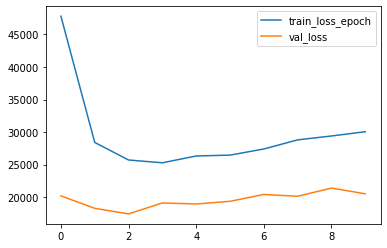

In [ ]:
# 結果確認
log = pd.read_csv('logs/helm_net/version_0/metrics.csv')

log[['train_loss_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss_epoch'].plot()
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot()
plt.legend()

#### 4-4-3-4. 学習後の generator でXを生成

正規分布からランダムサンプリングした値を潜在変数としてXを生成する。

VAEと比較すると、取得される結果がまちまちであることがわかる。  
この原因としては、wake-sleepでは、VAEと違って「潜在変数が正規分布に従うような補正」を受けていないためだと考えられる。

torch.Size([50, 2])


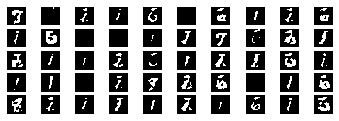

In [ ]:
with torch.no_grad():
    dummies = helm.sample(50)

for i, dummy in enumerate(dummies):
    x = dummy
    plt.subplot(10, 10, i + 1)
    plt.imshow(x, interpolation='nearest', cmap = "gray")
    plt.axis('off')

#### 4-4-3-5. 学習後のmanifoldの表示

manifoldを表示させると、潜在変数の値が近いところには、似たような画像が集まっていることが分かる。

この点についてはVAEに似たような結果となった。

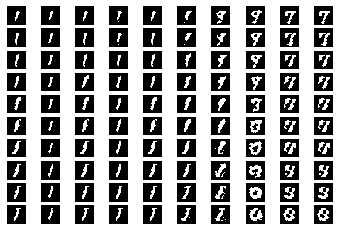

In [ ]:
with torch.no_grad():
    dummies = helm.manifold(10, 10)

for i, dummy in enumerate(dummies):
    x = dummy
    plt.subplot(10, 10, i + 1)
    plt.imshow(x, interpolation='nearest', cmap = "gray")
    plt.axis('off')

# 5. 参考資料

　今回のソースコードは、以下の記事やソースコードを元に修正を加えて実装しました。

- 記事(VAE)  
https://blog.octopt.com/variational-autoencoder/
- Github
    - VAE  
    https://github.com/octopt/techblog/blob/master/vae/main.py
    - wake-sleep  
    https://github.com/mrdrozdov/pytorch-machines/blob/master/helmholtz.py
